# Sentiment Analysis

## Dependencies

In [29]:
import re

import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.optimizer_v2.adagrad import Adagrad
from keras.layers import Embedding, Dense, Flatten
from keras.layers.convolutional import Conv1D, AveragePooling1D
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import Word2Vec

import emoji

## Loading Data

In [30]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [31]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT rating, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>10000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 60000) cat_samples, rating, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(rating)
WHERE sentiment != 1
GROUP BY rating
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [32]:
df.head()

,review,rating,sentiment
0,semoga pengiriman cepat dan barangnya ori,5,2
1,Snang blnja di toko pedia,5,2
2,Mantul,5,2
3,Best,5,2
4,Oke bgt,5,2


In [33]:
df.isna().sum()

review       5
rating       0
sentiment    0
dtype: int64

In [34]:
df = df.dropna(axis=0)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239995 entries, 0 to 239999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     239995 non-null  object
 1   rating     239995 non-null  int64 
 2   sentiment  239995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.3+ MB


### Preprocessing

In [36]:
def extract_emojis(sentence):
    return re.findall(emoji.get_emoji_regexp(), sentence)

In [37]:
def preprocessing_text(texts):
    emojis = extract_emojis(texts)
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = list(filter(lambda x: x, [x.lower() for x in texts.split(" ")]))

    return texts + emojis

In [38]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [39]:
df.head()

,review,rating,sentiment,review_cleaned
0,semoga pengiriman cepat dan barangnya ori,5,2,"[semoga, pengiriman, cepat, dan, barangnya, ori]"
1,Snang blnja di toko pedia,5,2,"[snang, blnja, di, toko, pedia]"
2,Mantul,5,2,[mantul]
3,Best,5,2,[best]
4,Oke bgt,5,2,"[oke, bgt]"


In [40]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

print(pd.DataFrame(word_length, columns=['word_length']).describe())
print(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

         word_length
count  239995.000000
mean       11.006583
std        13.911868
min         0.000000
25%         2.000000
50%         6.000000
75%        14.000000
max       264.000000
word_length    28.0
Name: 0.9, dtype: float64


In [41]:
tokenizer = Tokenizer(num_words=30000)

In [42]:
tokenizer.fit_on_texts(df['review_cleaned'])
seq = tokenizer.texts_to_sequences(df['review_cleaned'])
X = pad_sequences(seq, padding='post')

print(f'X_shape: {X.shape}, X_min: {np.min(X)}, X_max: {np.max(X)}')

X_shape: (239995, 259), X_min: 0, X_max: 29999


In [43]:
y = df['sentiment'].map({0:0, 2:1})

### Train-test split

In [44]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)
print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)

(153596, 259) (38400, 259) (47999, 259) (153596,) (38400,) (47999,)


## Prepare Embedding

In [45]:
embedding = Word2Vec(df['review_cleaned'], vector_size=100, window=5, workers=2, min_count=2)

In [46]:
words = len(embedding.wv)
print('Vocabulary size: %d' % words)

Vocabulary size: 28000


In [47]:
def get_weight_matrix(embedding: Word2Vec, vocab):
    vocab_size = len(vocab) + 1

    weight_matrix = np.zeros((vocab_size, 100))

    for word, i in vocab.items():
        try:
            weight_matrix[i] = embedding.wv.get_vector(word)
        except:
            continue
    
    return weight_matrix

In [48]:
embedding_vectors = get_weight_matrix(embedding, tokenizer.word_index)

In [49]:
vocab_size = len(tokenizer.word_index) + 1
max_length = X.shape[1]

In [50]:
def l2_norm1d(x):
    x = x ** 2
    output = K.sum(x, axis=1)
    output  = K.sqrt(output)
    return output

## Create Model Layers

In [51]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_vectors], input_length=max_length, trainable=True),
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', strides=2),
    AveragePooling1D(pool_size=2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 259, 100)          6907800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 128)          64128     
_________________________________________________________________
average_pooling1d_1 (Average (None, 65, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8320)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8321      
Total params: 6,980,249
Trainable params: 6,980,249
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [52]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
optimizer = Adagrad(learning_rate=0.01)
model.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/15
4800/4800 [==============================] - 194s 40ms/step - loss: 0.4124 - accuracy: 0.8263 - val_loss: 0.3939 - val_accuracy: 0.8411
Epoch 2/15
4800/4800 [==============================] - 192s 40ms/step - loss: 0.3834 - accuracy: 0.8410 - val_loss: 0.3860 - val_accuracy: 0.8422
Epoch 3/15
4800/4800 [==============================] - 191s 40ms/step - loss: 0.3739 - accuracy: 0.8450 - val_loss: 0.3826 - val_accuracy: 0.8454
Epoch 4/15
4800/4800 [==============================] - 192s 40ms/step - loss: 0.3669 - accuracy: 0.8485 - val_loss: 0.3793 - val_accuracy: 0.8451
Epoch 5/15
4800/4800 [==============================] - 192s 40ms/step - loss: 0.3611 - accuracy: 0.8511 - val_loss: 0.3775 - val_accuracy: 0.8460
Epoch 6/15
4800/4800 [==============================] - 192s 40ms/step - loss: 0.3559 - accuracy: 0.8529 - val_loss: 0.3764 - val_accuracy: 0.8472
Epoch 7/15
4800/4800 [==============================] - 191s 40ms/step - loss: 0.3513 - accuracy: 0.8546 - val_loss: 0

<AxesSubplot:>

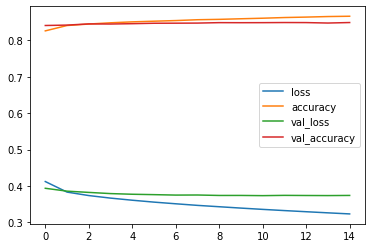

In [53]:
pd.DataFrame(history.history).plot()

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     24023
           1       0.84      0.85      0.85     23976

    accuracy                           0.85     47999
   macro avg       0.85      0.85      0.85     47999
weighted avg       0.85      0.85      0.85     47999



<AxesSubplot:>

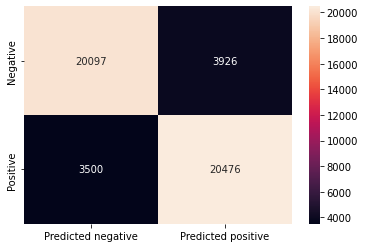

In [54]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

## Serializing Model

In [55]:
MODEL_NAME = 'CNN_Sentiment'
MODEL_VERSION = (3, 0, 1, 'E')
MODEL_DIRNAME = '_'.join([MODEL_NAME, '.'.join(map(str, MODEL_VERSION))])
MODEL_DIRNAME = 'Sentiment Analysis/CNN/' + MODEL_DIRNAME

In [56]:
model.save(MODEL_DIRNAME)

INFO:tensorflow:Assets written to: CNN_Sentiment_3.0.1.E/assets
